In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from legwork import evol, utils
import legwork as lw
import astropy.units as u
import astropy.constants as c

from scipy.integrate import cumtrapz, trapz
from scipy.interpolate import interp1d

from astropy.cosmology import Planck18, z_at_value

In [8]:
from utils import get_de_de10

In [9]:
def dg_de(f, e):
    prefac = (19 / 18) * (1 / f) 
    numerator = 6 * (4477 * e**8 + 99225 * e**6 + 145260 * e**4 + 141472 * e**2 - 29184)
    denominator = 19 * (37 * e**4 + 292 * e**2 + 96)**2
    
    return prefac * numerator / denominator

def dTmerger_df(m1, m2, f, e):
    beta = lw.utils.beta(m1, m2)
    ecc_fac = (1 - e**2)**(7/2) * (1 + 0.27 * e**10 + 0.33 * e**20 + 0.2 * e**1000)
    dt_df = -2 / 3 * (c.G * (m1 + m2) / (4 * np.pi**2))**(4/3) / beta * f**(-11/3)
    
    return ecc_fac * dt_df

def dTmerger_df_circ(m1, m2, f):
    beta = lw.utils.beta(m1, m2)
    dt_df = -2 / 3 * (c.G * (m1 + m2) / (4 * np.pi**2))**(4/3) / beta * f**(-11/3)
    
    return dt_df

def create_timesteps(t_evol=-100*u.yr, nstep_fast=100, nstep=20):
    t_chunks = np.logspace(0, np.log10(-1*t_evol.to(u.s).value), 10)
    t_lo = t_chunks[0]
    times = np.logspace(-2, np.log10(t_lo), nstep_fast)
    timesteps = -1 * times * u.s
    for t in t_chunks[1:]:
        times = np.logspace(np.log10(t_lo), np.log10(t), nstep_fast)
        timesteps = np.append(timesteps, -1 * times * u.s)
        t_lo = t
    return timesteps

def get_t_evol_LISA(m1, m2, e_LIGO=1e-5, f_LIGO=10*u.Hz, f_LISA=1e-5*u.Hz):
    if e_LIGO == 0:
        timesteps = create_timesteps(t_evol = -(100000000000)* u.yr, nstep_fast=50 * max(1, int(0.5 * e_LIGO/1e-4)))

        a_evol, f_evol = evol.evol_circ(
            m_1=m1, m_2=m2, f_orb_i=f_LIGO, timesteps=timesteps,
            output_vars=["a", "f_orb"])
    
    else:
        timesteps = create_timesteps(t_evol = -(1000/e_LIGO)* u.yr, nstep_fast=50 * max(1, int(0.5 * e_LIGO/1e-4)))
        a_evol, e_evol, f_evol = evol.evol_ecc(
            m_1=m1, m_2=m2, f_orb_i=f_LIGO, ecc_i=e_LIGO, timesteps=timesteps,
            t_before=0.01*u.yr, output_vars=["a", "ecc", "f_orb"], avoid_merger=False)
    
    t_interp = interp1d(a_evol, timesteps)
    a_lo = utils.get_a_from_f_orb(m_1=m1, m_2=m2, f_orb=f_LISA)  
    t_LISA = t_interp(a_lo)

    return t_LISA * u.s

def dNdVde_primedMcdf(dNdVdedMcdt, m1, m2, f_LIGO, e_LIGO):
    # get time to merger for f_LISA = 1e-4 Hz
    t_evol = get_t_evol_LISA(m1, m2, e_LIGO, f_LIGO, f_LISA=1e-5*u.Hz)
    
    # create timesteps
    timesteps = create_timesteps(t_evol, nstep_fast=50 * max(1, int(0.5 * e_LIGO/1e-4)))
    
    if e_LIGO == 0:
        a_evol, f_orb_evol = evol.evol_circ(
            m_1=m1, m_2=m2, f_orb_i=f_LIGO, timesteps=timesteps,
            output_vars=["a", "f_orb"])
        ecc_evol = np.zeros(len(f_orb_evol))
    else:
        f_orb_evol, ecc_evol = evol.evol_ecc(
            m_1=m1, m_2=m2, f_orb_i=f_LIGO, ecc_i=e_LIGO, timesteps=timesteps,
            t_before=0.01*u.yr, output_vars=["f_orb", "ecc"], avoid_merger=False)
        
    lnJ = -cumtrapz(dg_de(f_orb_evol, ecc_evol), f_orb_evol, initial=0)
    de_deprime = np.exp(lnJ)
    
    
    dNdVde_LISAdMcdf = dNdVdedMcdt * -1 * dTmerger_df(m1, m2, f_orb_evol, ecc_evol) * de_deprime
    
    return f_orb_evol, ecc_evol, timesteps, dNdVde_LISAdMcdf.to(u.Mpc**(-3)/u.Hz)

    
    

### Need to create a way to get the evol time back to f_orb = 1e-4 Hz

In [10]:
np.exp(trapz(dg_de(np.logspace(1, -4, 100), 0.0), np.logspace(1, -4, 100)))

194841.66017601153

In [11]:
f = utils.get_f_orb_from_a(m_1=30 * u.Msun, m_2=30 * u.Msun, a=10 * u.Rsun)  
print(f)

2.4474767157734467e-05 Hz


In [12]:
t_LISA = get_t_evol_LISA(m1=10*u.Msun, m2=10*u.Msun, e_LIGO=1e-4, f_LIGO=10*u.Hz, f_LISA=1e-4*u.Hz)


In [13]:
LIGO_rate = 20 * u.Gpc**(-3) * u.yr**(-1)
m1 = 100
m2 = 50

In [14]:
f_lo, e_lo, t_lo, dNdVde_LISAdMcdf_lo = dNdVde_primedMcdf(LIGO_rate, m1=m1*u.Msun, m2=m2*u.Msun, f_LIGO=10*u.Hz, e_LIGO=0.0)
f_mid, e_mid, t_mid, dNdVde_LISAdMcdf_mid = dNdVde_primedMcdf(LIGO_rate, m1=m1*u.Msun, m2=m2*u.Msun, f_LIGO=10*u.Hz, e_LIGO=1e-5)
f_hi, e_hi, t_hi, dNdVde_LISAdMcdf_hi = dNdVde_primedMcdf(LIGO_rate, m1=m1*u.Msun, m2=m2*u.Msun, f_LIGO=10*u.Hz, e_LIGO=0.0001)

e_labels=['0', '1e-5', '1e-4']
mc = utils.chirp_mass(m_1=m1*u.Msun, m_2=m2*u.Msun)
print(mc)

60.836434189320556 solMass


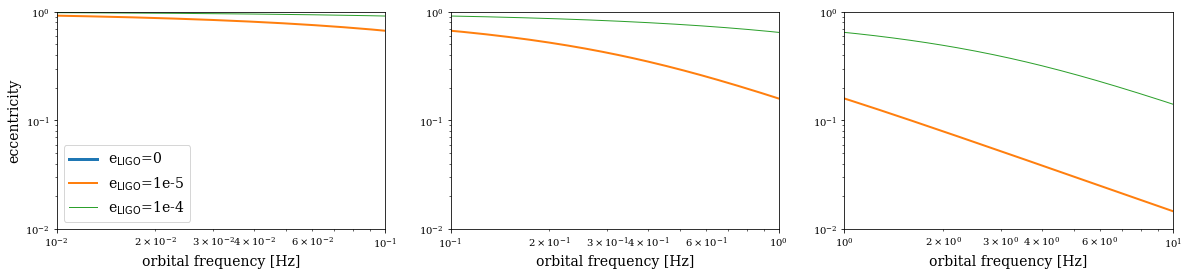

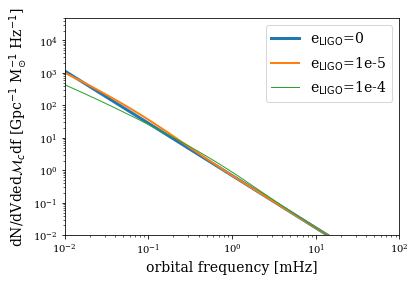

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(20,4))
x_lo_lim = [1e-2, 1e-1, 1]
x_hi_lim = [1e-1, 1, 10]

y_lo_lim = [50 * 1e9, 5e-2 * 1e9, 1e-4 * 1e9]
y_hi_lim = [5e-3 * 1e9, 1e-5 * 1e9, 5e-8 * 1e9]




for ii, ax in enumerate(axs):
    for jj, f, e, mc, elabel in zip(range(3), [f_lo, f_mid, f_hi], [e_lo, e_mid, e_hi], [mc, mc, mc], e_labels):
        ax.plot(f*1000, e, label=r'e$_{\rm{LIGO}}$='+elabel, lw=3 - jj)
    if ii == 0:
        ax.legend(prop={'size':14})
        ax.set_ylabel(r'eccentricity', size=14)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('orbital frequency [Hz]', size=14)
    ax.set_xlim(x_lo_lim[ii], x_hi_lim[ii])
    ax.set_ylim(0.01, 1)
    ax.tick_params(which='both', labelsize=10)
    #ax.set_xticks(np.logspace(np.log10(x_lo_lim[ii]), np.log10(x_hi_lim[ii]), 3))

fig, ax = plt.subplots(1, 1, figsize=(6,4))
for jj, f, rate, mc, elabel in zip(range(3), [f_lo, f_mid, f_hi], [dNdVde_LISAdMcdf_lo, dNdVde_LISAdMcdf_mid, dNdVde_LISAdMcdf_hi], [mc, mc, mc], e_labels):
    ax.plot(f*1000, cumtrapz(rate.to(u.Gpc**(-3) * u.Hz**(-1)), -f, initial=0), label=r'e$_{\rm{LIGO}}$='+elabel, lw=3 - jj)
ax.legend(prop={'size':14})
ax.set_ylabel(r'dN/dVded$\mathcal{M}_c$df [Gpc$^{-1}$ M$_{\odot}^{-1}$ Hz$^{-1}$]', size=14)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('orbital frequency [mHz]', size=14)
ax.set_xlim(0.01, 100)
ax.set_ylim(0.01, 50000)
ax.tick_params(which='both', labelsize=10)
#ax.set_xticks(np.logspace(np.log10(x_lo_lim[ii]), np.log10(x_hi_lim[ii]), 3))


### Now we can calculate the horizon distance for these tracks

In [16]:
fig1 = plt.figure(figsize=(6, 4))
for f, e, rate, label in zip([f_lo, f_mid, f_hi], [e_lo, e_mid, e_hi], [dNdVde_LISAdMcdf_lo, dNdVde_LISAdMcdf_mid, dNdVde_LISAdMcdf_hi], e_labels):
    ind_evol, = np.where(f < 1e-1 * u.Hz)
     
    e = e[ind_evol]
    f = f[ind_evol]
    rate = rate[ind_evol]
    source = lw.source.Source(m_1=m1*u.Msun * np.ones_like(e),
                              m_2=m2*u.Msun * np.ones_like(e),
                              ecc=e,
                              f_orb=f,
                              dist=8 * np.ones_like(e) * u.Mpc,
                              interpolate_g=False,
                              n_proc=1,
                             )
    
    snr = source.get_snr(approximate_R=True)
    D_h = snr/7 * 8 * u.Mpc
    redshift = np.ones(len(D_h)) * 1e-8
    redshift[D_h > 0.0001 * u.Mpc] = z_at_value(Planck18.luminosity_distance, D_h[D_h > 0.0001 * u.Mpc])
    V_c = Planck18.comoving_volume(z=redshift)
    
    #plt.plot(f, cumtrapz(rate.to(u.Gpc**(-3) * u.Hz**(-1)) * V_c.to(u.Gpc**3), -f, initial=0) )
    
    plt.plot(f, V_c.to(u.Gpc**3))
    plt.xscale('log')
    plt.yscale('log')
#plt.ylim(1e-4, 1e-1)
plt.show()
plt.close()
        
   #fig2 = plt.figure(figsize=(6, 4))
   #print(rate * V_c)
   #
   #plt.scatter(f,cumtrapz(rate * V_c, -f, initial=0), label=f'e={label}', s=5)
   #
   ##cbar.set_ticklabels(ticklabels=np.linspace(0.0, 1.0, 5), size=10)
   #plt.xlabel('orbital frequency [Hz]', size=14)
   #plt.xlim(1e-5, 1e-1)
   #plt.xscale('log')
   #plt.yscale('log')
   #plt.tick_params(labelsize=10)
   #plt.ylabel(r'integrated rate', size=14)
   #plt.legend(prop={'size':14})
   #plt.show()
   #plt.close()
   #

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x1555219b23a0> (for post_execute):


KeyboardInterrupt: 

In [44]:
source = lw.source.Source(m_1=m1*u.Msun * np.ones_like(e_hi[-2:]),
                              m_2=m2*u.Msun * np.ones_like(e_hi[-2:]),
                              ecc=e_hi[-2:],
                              f_orb=f_hi[-2:],
                              dist=8 * np.ones_like(e_hi[-2:]) * u.Mpc,
                              interpolate_g=False,
                              )

In [45]:
len(f_hi[e_hi > 0.99])

0

In [ ]:
source.get_snr(verbose=True)

## cool! You can run LW backwards instead of forwards!

In [53]:
n_pop = 1
ecc_i = 10**np.random.normal(loc=-12, scale=0.25, size=n_pop)
m_1 = np.random.normal(loc=30, scale=5, size=n_pop) * u.Msun
m_2 = np.random.normal(loc=30, scale=5, size=n_pop) * u.Msun
forb_i = 0.1 * u.Hz
t_evol = -100 * u.yr


## need to calculate t_evol for each forb_LISA

In [54]:
f_orb_evol, ecc_evol = evol.evol_ecc(t_evol=-10000 * u.yr, n_step=100000, m_1=m_1, m_2=m_2, 
                                     f_orb_i=forb_i, ecc_i=ecc_i, avoid_merger=True,
                                     t_before=0.01*u.yr, output_vars=["f_orb", "ecc"])
    
m_c = utils.chirp_mass(m_1, m_2)

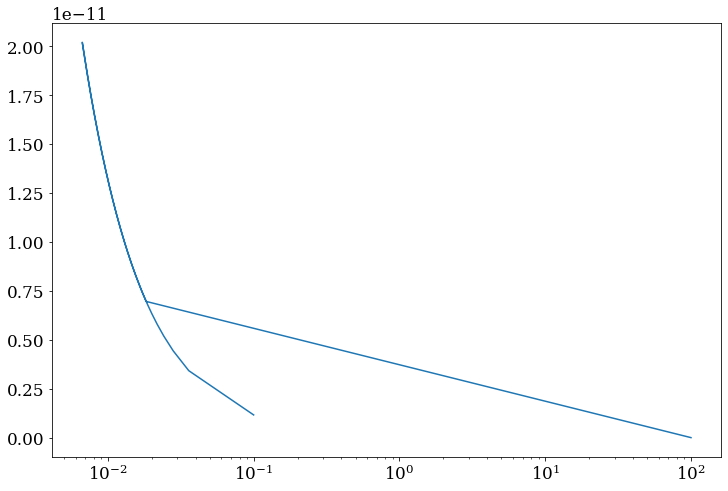

In [55]:
plt.plot(f_orb_evol, ecc_evol)
plt.xscale('log')

In [56]:
f_orb_evol, ecc_evol

(<Quantity [1.00000000e-01, 3.58920340e-02, 2.80475657e-02, ...,
            1.00000000e+02, 1.00000000e+02, 1.00000000e+02] Hz>,
 array([1.16096966e-12, 3.42408968e-12, 4.44220081e-12, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]))

0.10000000000000017 Hz


(0.0001, 10.0)

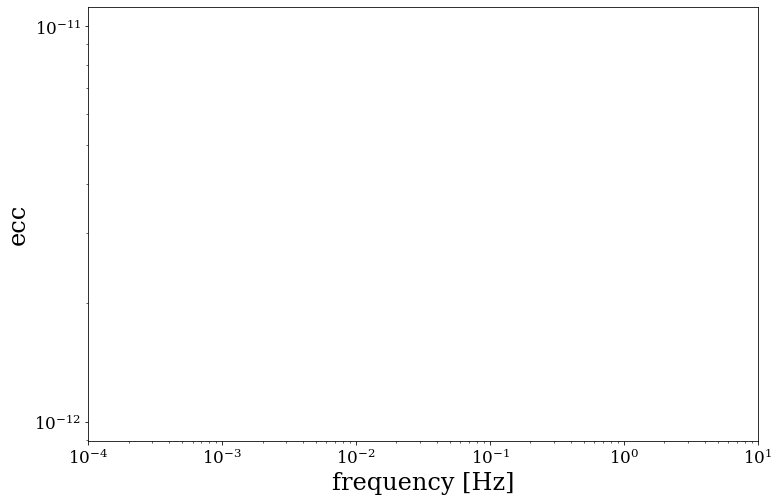

In [58]:
for f, e, mc in zip(f_orb_evol, ecc_evol, m_c):
    print(f)
    plt.plot(f, e, c='silver')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('frequency [Hz]')
plt.ylabel('ecc')
plt.xlim(1e-4, 1e1)

In [32]:
source = lw.source.Source(m_1=m_1,
                          m_2=m_2,
                          ecc=ecc_evol[:, -1],
                          f_orb=f_orb_evol[:, -1],
                          dist=8 * np.ones(100) * u.Mpc,
                          interpolate_g=False)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
snr = source.get_snr()

In [ ]:

plt.hist(D_h.value)
plt.xlabel('horizon distance [Mpc]')

In [ ]:
n_pop = 100
ecc_i = 10**np.random.normal(loc=-6, scale=0.25, size=n_pop)
m_1 = np.random.normal(loc=30, scale=5, size=n_pop) * u.Msun
m_2 = np.random.normal(loc=30, scale=5, size=n_pop) * u.Msun
forb_i = np.ones(n_pop) * 0.1 * u.Hz
t_evol = np.ones(n_pop) * -10000 * u.yr


In [ ]:
f_orb_evol, ecc_evol = evol.evol_ecc(t_evol=t_evol, n_step=10000, m_1=m_1, m_2=m_2, f_orb_i=forb_i, ecc_i=ecc_i,
                                     t_before=0.1*u.yr, output_vars=["f_orb", "ecc"])
    
m_c = utils.chirp_mass(m_1, m_2)

In [ ]:
for f, e, mc in zip(f_orb_evol, ecc_evol, m_c):
    plt.plot(f, e, c='salmon')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('orbital frequency [Hz]')
plt.ylabel('ecc')
plt.xlim(1e-4, 1e1)

### need to get dg/de and dTmerger/df in functions:

In [ ]:
f, e
f

In [ ]:
#np.exp(lnJ)

In [ ]:
plt.hist(np.log10(f.value))

In [ ]:
plt.plot(f, e)
plt.xscale('log')
plt.yscale('log')

In [ ]:
plt.plot(f, dg_de(f, e))
plt.xscale('log')

In [ ]:
plt.plot(f, e)
plt.xscale('log')
plt.yscale('log')

In [ ]:
f, dTmerger_df(m1, m2, f, e).to(u.s**2)

In [ ]:
plt.plot(f, abs(dTmerger_df(m1, m2, f, e).to(u.s**2)))
plt.yscale('log')
plt.xscale('log')

In [ ]:
plt.plot(f, dNdVdedMcdt * dTmerger_df(m1, m2, f, e).to(u.s**2) * dg_de(f, e).to(u.s))
plt.xscale('log')
plt.yscale('log')
#plt.xlim(1e-3, 1e-1)
#plt.ylim(1e7, 1e18)

In [ ]:
dNdVdedMcdt * dg_de(f, e) * dTmerger_df(m1, m2, f, e)

In [ ]:
n_pop = 100
ecc_i = 0.0
m_1 = 40.0 * u.Msun
m_2 = 30.0 * u.Msun
forb_i = np.ones(n_pop) * 10 * u.Hz
t_evol = np.ones(n_pop) * -100000 * u.yr

In [ ]:
f_orb_evol = evol.evol_circ(t_evol=t_evol, n_step=100000, m_1=m_1, m_2=m_2, f_orb_i=forb_i, 
                                      output_vars=["f_orb"])
    
m_c = utils.chirp_mass(m_1, m_2)

In [ ]:
f_orb_evol

In [ ]:
e_evol = 0.0

In [ ]:
plt.plot(f_orb_evol, dTmerger_df_circ(m_1, m_2, f_orb_evol).to(u.s**2) * dg_de(f_orb_evol, e_evol) * dNdVdedMcdt)
plt.xscale('log')
plt.yscale('log')

In [ ]:
plt.plot(f_orb_evol, abs(dTmerger_df_circ(m_1, m_2, f_orb_evol)))
plt.xscale('log')
plt.yscale('log')